In [1]:
%matplotlib inline

from __future__ import division
import csv
import matplotlib.pyplot as plt
import numpy as np
import random
import time
from scipy import signal
from scipy import optimize
import pylab
import csv
from basic_definitions import *
from math import floor
import time      
from IPython.core.debugger import Tracer
import matlab.engine
from tqdm import tqdm
import scipy
from collections import Counter, defaultdict
from itertools import count




In [2]:
def digitize_wind(x,J_max,uniform=False):
    if uniform:
        x_sorted = np.array(sorted(x))
        bin_edge = np.linspace(0,len(x),num=J_max, endpoint=False, dtype=int)
        bins = x_sorted[bin_edge]
    else:
        bins = np.linspace(min(x),max(x),J_max)
    
    bins_states = np.append(bins,max(x))
    bin_means = []
    for i in range(J_max):
        bin_means.append((bins_states[i]+bins_states[i+1])/2)

    return np.digitize(x,bins)-1, np.array(bin_means)

WindSpeed is not a float


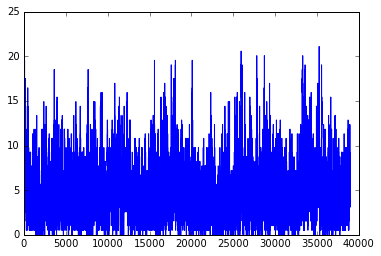

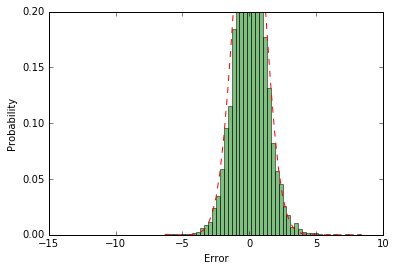

Mean:  0.000139676389468   Std:  1.15544841431
0
[-5.79962817 -4.23461792 -2.66960766 -1.10459741  0.46041285  2.0254231
  3.59043335  5.15544361  6.72045386  8.28546412  9.06796924]


[-5.79962817 -4.23461792 -2.66960766 -1.10459741  0.46041285  2.0254231
  3.59043335  5.15544361  6.72045386  8.28546412  9.06796924]


In [3]:
Speed = get_wind_data('Filton_wind_record.csv',col=5) # Filton_wind_record col=9   WindData col = 4 
spd_all = []
for i in Speed:
    try:
        spd_all.append(float(i)*0.514444)
        
    except ValueError:
        print i + " is not a float"

# filter out negative wind speeds
spd_all[:] = (value for value in spd_all if value >= 0)
#print len(spd_all)        
        
plt.plot(spd_all)
plt.show()
# how many years are analysed        
years = 1
spd = spd_all[0:365*24*years]        

# settings
J_max = 11



        
# SAVGOL 
# S = scipy.signal.savgol_filter(spd,35,2) 
# Forecast = scipy.signal.savgol_filter(spd_all,35,2) 

# Low Pass
b, a = scipy.signal.butter(2, 0.1, 'low') #4, 100, 'low'
S = scipy.signal.filtfilt(b, a, spd)
Forecast = scipy.signal.filtfilt(b, a, spd_all)

f, Pxx_den = signal.periodogram(S)
plt.semilogy(f, Pxx_den)
#plt.axis([0,1,0,100])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()


plt.plot(spd_all[0:24],label='Wind')
plt.plot(S[0:24],label='Forecast')
plt.axis([0,24,0,25])
plt.show()


# Median filter
#S = scipy.signal.medfilt(spd,5)
err = spd-S # error of forecast compared to realisation
err_all = spd_all - Forecast

# Stat analysis of err
#n, bins, patches = plt.hist(Err, bins=20,normed=1, facecolor='blue', alpha=0.5)
n, bins, patches = plt.hist(err, bins=50,normed=1, facecolor='green', alpha=0.5)

y = plt.mlab.normpdf(bins, err.mean(), err.std())
plt.plot(bins, y, 'r--')
plt.xlabel('Error')
plt.ylabel('Probability')
plt.axis([-15,10,0,0.2])
plt.show()
print  "Mean: ", err.mean(),"  Std: ", err.std()

# def discretise_wind(x,J_max=21,factor=None):
#     #print Hmax,Hmin
#     x_sorted = np.sort(x)
#     bins = lins
#     np.digitize(x)
    
#     if factor is None and J_max is not None:
#         factor = float(J_max/ (max(x)-min(x)))
#     elif factor is None and len(x)== 1:
#         raise ValueError('x must be series if no factor is provided, also provide J_max')
        
#     # discretise the levels of storage
#     G = [np.round(i*factor)/factor for i in x]
#     if len(set(G)) > J_max:
#         G = [np.floor(i*factor)/factor for i in x]
        
#     # if still too large:
#     if len(set(G)) > J_max:
#         mG = max(set(G))
#         G = [i for i in G if i < mG]
        
#     return np.array(G),factor


states, state_errors = digitize_wind(err_all,J_max)
#states, state_errors = digitize_wind(err,J_max)

print min(states)
print state_errors

n, bins, patches = plt.hist(states, bins=50,normed=1, facecolor='green', alpha=0.5)
plt.show()



Err = np.array([state_errors[i] for i in states])

print state_errors
#set_of_Err_total = range(J_max)#sorted(set(Err))

# Transition matrix
#Err = [i for i in Err if i >= 10]


# ax.set_yticklabels([state_to_Err[0],state_to_Err[5],state_to_Err[10],state_to_Err[15],state_to_Err[20]])
# ax.set_xticklabels([state_to_Err[0],state_to_Err[5],state_to_Err[10],state_to_Err[15],state_to_Err[20]])
# #savefig('T_matrix_data.png')
# plt.show()

#print Err_to_state # dict of Err : state 



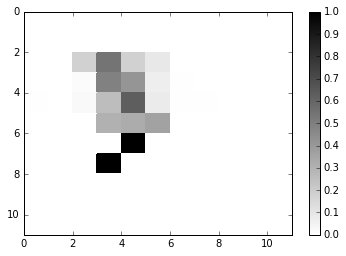

In [4]:
def tmatrix(lst,J_max):
    """from http://stackoverflow.com/questions/28013878/calculate-transition-matrix-of-letters?lq=1
    defaultdict that'll produce a unique index for each unique character
    encountered in lst
    """

    # add thing to normalise
    a_state_chain = []# will contain each change of state twice
    for i in range(J_max):
        chain =  np.zeros(2*J_max)+int(i)
        chain = chain.tolist()
        for j in range(J_max):
            chain[j*2+1] = j

        a_state_chain.extend(chain)

    a_state_chain.append(0)

    lst = lst.tolist()
    lst.extend(a_state_chain) #don't use last J_max * J_max + 1 states
    lst = np.array(lst)
    
    
    
    indices = defaultdict(count().next)
    b = np.zeros([J_max,J_max])
    
    Ct = Counter(zip(lst, lst[1:])) # zip together consecutive elements of the list

    for (x, y), c in iter(sorted(Ct.iteritems())): # make sorted iteration to generate sorted trasition matrix
        #print (x,y), c
        b[indices[x]][indices[y]] = float(c)
       
    res = dict((v,k) for k,v in indices.iteritems())
    
    b = np.array(b)
    b = b-2 # remove the bit added for normalisations

    ##Normalise 
    for i in range(J_max):
        if float(b.sum(axis=1)[i]) > 0:
            b[i] = b[i]/float(b.sum(axis=1)[i])
        else:
            #  only zeros
            b[i] = b[i]
    
    # throw error if nan value
    if np.isnan(np.sum(b)):
        print b
        raise ValueError("NaN in T_mat")
       
    
    # sort!
    #output = np.zeros([J_max,J_max])
    #print len(res)
    
#     for i in range(20):
#         output[i] = b[res[i]]
        
    return b#, indices    
    #return output, indices

#T_mat, Err_to_state =  tmatrix(Err,J_max)

T_mat =  tmatrix(states[500:1000],J_max)
#print Err_to_state


#print set(Err)
c = plt.pcolor(T_mat)
plt.set_cmap('gray_r')
plt.colorbar()
plt.axis([0,len(T_mat),0,len(T_mat)])
ax=plt.gca()                            # get the axis
ax.set_ylim(ax.get_ylim()[::-1])
#state_to_Err = dict((value, key) for key, value in Err_to_state.iteritems())

#xx, locs = plt.xticks()
#ll = ['%.3f' % a for a in xx]
#plt.xticks([state_to_Err[0],state_to_Err[10],state_to_Err[20]],[0, 11, 21])
plt.show()

T_mat =  tmatrix(states[0:500],J_max)
#print Err_to_state


#print set(Err)
c = plt.pcolor(T_mat)
plt.set_cmap('gray_r')
plt.colorbar()
plt.axis([0,len(T_mat),0,len(T_mat)])
ax=plt.gca()                            # get the axis
ax.set_ylim(ax.get_ylim()[::-1])
#state_to_Err = dict((value, key) for key, value in Err_to_state.iteritems())

#xx, locs = plt.xticks()
#ll = ['%.3f' % a for a in xx]
#plt.xticks([state_to_Err[0],state_to_Err[10],state_to_Err[20]],[0, 11, 21])
plt.show()

In [5]:
def make_T_mat(wind,J_max=21,filter_order=2,filter_level=0.01,offset=0):
    """
    Makes all the wind stats needed. Does not include the time from 
    end to offset in probability matrix generation.
    """
    b, a = scipy.signal.butter(filter_order,filter_level,'low') #4, 100, 'low'
    Forecast = scipy.signal.filtfilt(b,a,wind)
    #Err,factor = discretise_wind(wind-Forecast,J_max=J_max)
    #print "Forecast ", np.shape(Forecast)

    states, state_errors =digitize_wind(wind[:-1-offset]-Forecast[:-1-offset],J_max)
    #print "len(set(states)) ", len(set(states))
    
    Err = np.array([state_errors[i] for i in states])
    #T_mat, Err_to_state =  tmatrix(Err,J_max)
    T_mat =  tmatrix(states,J_max)
    
    Err_to_state = dict(zip(state_errors,range(J_max)))
    
    return T_mat, Err_to_state, state_errors, Err, Forecast

# T_mat, Err_to_state, state_errors, Err, Forecast = make_T_mat(spd_all,J_max=51, offset=0)
# #print T_mat
# c = plt.pcolor(T_mat)
# plt.set_cmap('gray_r')
# plt.colorbar()
# plt.axis([0,len(T_mat),0,len(T_mat)])
# ax=plt.gca()                            # get the axis
# ax.set_ylim(ax.get_ylim()[::-1])
# #print "Err_to_state, state_errors"
# #print Err_to_state, state_errors
# state_to_Err = dict((value, key) for key, value in Err_to_state.iteritems())
# plt.show()


In [6]:
def simple_scheduler(cost,min_pump_ops=0):
    """Takes a cost schedule and pumps at the minimum cost,
    pumps as many times as specified by the min_pump_ops"""
    
    cost_sort = sorted(cost.tolist())[0:min_pump_ops]
    print cost_sort
    sched =[]
    for i in cost:
        if i in cost_sort:
            sched.append(1)
            cost_sort.remove(i)
        else:
            sched.append(0)
            
    return np.array(sched)

In [7]:
state_errors

array([-5.79962817, -4.23461792, -2.66960766, -1.10459741,  0.46041285,
        2.0254231 ,  3.59043335,  5.15544361,  6.72045386,  8.28546412,
        9.06796924])

In [8]:
print Cost_true[0:24]*Schedule_det[1]
print Forecast

NameError: name 'Cost_true' is not defined

  0%|                                                 | 0/1000 [00:00<?, ?it/s]

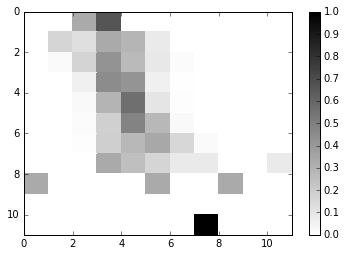

 20%|███████▍                             | 200/1000 [27:17<1:42:18,  7.67s/it]

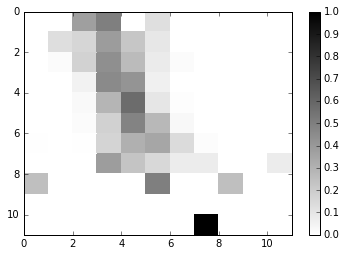

 40%|██████████████▊                      | 400/1000 [55:11<1:27:39,  8.77s/it]

100%|████████████████████████████████████| 1000/1000 [2:27:17<00:00,  8.01s/it]


In [9]:
## Network Settings
tank = Tank(Elev=20,Hmin=0,Hmax=2,Dia=10,levels = 100)
Pipe = pipe(L = 1000,D = 0.5,Method = "DW")
pump = Hyd_pump("ETAline-100-100-210-FSD.crv")
Demand = [0.0379, 0.0398, 0.0426, 0.0473, 0.0379, 0.0369, 0.0426, 0.0530, 0.0568, 0.0757, 0.1325, 0.1609, 0.1704, 0.1515, 0.1136, 0.0947, 0.0757, 0.0710, 0.0682, 0.0663, 0.0710, 0.0663, 0.0757,  0.0776, 0.0757, 0.0748, 0.0899, 0.1041, 0.1231, 0.1136, 0.1041, 0.1325, 0.1515, 0.1562, 0.1704, 0.2083, 0.1609, 0.1704, 0.1231, 0.1136, 0.0757, 0.0663, 0.0473, 0.0426, 0.0379, 0.0379, 0.0379, 0.0360]
change_in_H = np.array(Demand)*60*60/4/tank.Area/10/0.89993

#stepsize = 0.2

T = 24
d_fact = 0.7


pump_perf = gen_flow_rate(tank.levels,tank,Pipe,pump,100)
Demand_DP = np.array(change_in_H)/2
Demand_DP = list_length_adjustment(Demand_DP,T)

tot_det = []
tot_dp = []
tot_dp_rej = []
tot_det_rej = []
tot_det_planned_rej = []
tot_det_planned = []
tot_det_1 = []
tot_dp_1 = []
tot_det_planned_1 = []
tot_perf = []
tot_dp_cor = []




def compute_stoch_cost2(T,Cost_true,state_true,schedule_DP,P_matrix,J_max,change_in_H,d_fact,H_rec,tank,pump_perf):   
    """
    Computes the operating cost given the actual wind realisations,
    a schedule to follow, the pump conditions and the probability
    matrix.
    
    Computes the stochastic operating cost given
    a certain schedule and the way the wind behaves.
    """
    #DP stuff
    Tot_cost_DP = schedule_DP[1+state_true[0],0]*Cost[state_true[0],0]
    Tot_cost_DP += schedule_DP[1+state_true[1],1]*Cost[state_true[1],1]
    sched_stoch_used = [schedule_DP[1+state_true[0],0], schedule_DP[1+state_true[1],1]]
    for i in range(2,T):        
        Cost_sim = Cost[:,i:i+24]
        Demand=np.roll(change_in_H*d_fact,-i)
        #print Demand
        Calc_Cost, schedule_DP, H_init, h_final, final_val,  H_rec = \
            call_val(H_rec[state_true[i]][1], t_init=0, j_init=state_true[i], T=T,Demand=Demand,\
            Energy=Cost_sim, J_max=J_max,P_matrix = P_matrix,tank=tank, pump_perf=pump_perf)
        #print schedule_DP[1,1+J_seq[i]]
        Tot_cost_DP += schedule_DP[1+state_true[i],1]*Cost_true[i]
        
        if ~np.isnan(schedule_DP[1+state_true[i],1]):
            sched_stoch_used.append(int(schedule_DP[1+state_true[i],1]))
        else:
            sched_stoch_used.append(0)
        
    # normalise schedule cost:
    sched_stoch_used = np.array(sched_stoch_used)
    #print sum(sched_stoch_used)    

        
    
    return Tot_cost_DP, sched_stoch_used


T_mat_hist= []
Forecast = scipy.signal.filtfilt(b, a, spd_all)
for day in tqdm(range(1000)):
    #print day
    init = 365*24*years+24*day # set what day do analyse
    wind_true = np.array(spd_all[init:init+48])
    #print "len(spd_all[0:init+48])", len(spd_all[0:init+48])
    T_mat, Err_to_state, state_errors, Err, Forecast = make_T_mat(states[0:init+48],J_max=J_max,offset=48)
    #T_mat, Err_to_state, state_errors, Err, Forecast = make_T_mat(spd_all[0:init+48],J_max=J_max,offset=48)
    
    T_mat_hist.append(T_mat)
    
    if day in [0,200,400]:
        c = plt.pcolor(T_mat)
        plt.set_cmap('gray_r')
        plt.colorbar()
        plt.axis([0,len(T_mat),0,len(T_mat)])
        ax=plt.gca()                            # get the axis
        ax.set_ylim(ax.get_ylim()[::-1])
        plt.show()
    
    
    A = np.array(Forecast[-49:-1])
    #print "A", len(A)
    #print np.shape(T_mat)
    
    Err_day = Err[-48:]
    #print np.shape(Energy)
    #Err_day = discretise_wind(wind_true-A,factor=factor )  
    #Err_day = Err[init:init+48]
    #print Err_day
    state_true =[]
    #print len(Err_day[0])
    for i in Err_day:
        #print i
        #print Err_to_state
        #print Err_to_state(i)
        
        state_true.append(Err_to_state[i])
        
    #print "state_true len", len(state_true)
    
    
    
    Tariff = [5.7180, 5.7180, 5.7180, 5.7180, 5.7180, 5.7180, 5.7180, 5.7180, 5.7180, 5.7180, 5.7180, 17.1520, 17.1520, 17.1520, 17.1520, 17.1520, 17.1520, 17.1520, 17.1520, 9.6980, 9.6980, 9.6980, 9.6980, 9.6980, 9.6980, 9.6980, 9.6980, 9.6980, 9.6980, 9.6980, 9.6980, 9.6980, 9.6980, 17.1520, 17.1520, 17.1520, 17.1520, 17.1520, 17.1520, 17.1520, 9.6980, 9.6980, 9.6980, 9.6980, 5.7180, 5.7180, 5.7180, 5.7180]
    Tariff = list_length_adjustment(Tariff,T)
    Tariff.extend(Tariff)

    #print "len(set_of_Err_total) ", len(set_of_Err_total)
    D = np.array(A,ndmin=2)+np.array(state_errors,ndmin=2).T # set of possible wind ranges
    #D = provide_speed_range(A,stepsize=stepsize,number_of_steps=J_max)
    #D = provide_speed_range(A,number_of_steps=J_max,f=[0.2,0.3])
    #print "D ",np.shape(D)

    Pwr = np.zeros_like(D)
    Cost = np.zeros_like(D)
    Cost_true= np.zeros_like(wind_true)
    #print wind_true
    for i in range(0,np.shape(D)[0]):
        Cost_true[i] = max((2500-Turb_power(wind_true[i],Cutoff=25))*Tariff[i],0) 
        for j in range(0,np.shape(D)[1]):
            Pwr[i,j] = Turb_power(D[i,j],Cutoff=25)
            Cost[i,j] = max( (2500-Pwr[i,j])*Tariff[i],0)

    #print Cost_true
    #print np.shape(Cost)
    Cost_for_DP = Cost
    #print np.shape(Cost)
    
    Cost_for_det = Cost[int(np.floor(J_max/2.0)),:].tolist()
    
    
    #print "Av. det cost ", np.array(Cost_for_det).mean(),  
    #print "Av. true cost ", Cost_true.mean(),
    #print "Av. stoch cost ", Cost.mean(),
    
    #print np.shape(Cost_for_det), np.shape(Cost_for_DP), np.shape(Cost_true), 
    
    # Deterministic    
    Calc_Cost_det, Schedule_det, H_init_det, h_final_det, final_val_det = \
    call_val_det(H_init=1.0, t_init=0, j_init=state_true[0], T=24,Demand=change_in_H*d_fact,\
                                                           Energy=Cost_for_det, tank=tank, pump_perf=pump_perf)
    
    Tot_cost_det =np.dot(Cost_true[0:24],np.array(Schedule_det[1]))
    #
    #print "Schedule det ", Schedule_det[1]
    
    
    # Perfect
    Calc_Cost_perf, Schedule_perf, H_init_perf, h_final_perf, final_val_perf = \
    call_val_det(H_init=1.0, t_init=0, j_init=state_true[0], T=24,Demand=change_in_H*d_fact,\
                                                           Energy=Cost_true, tank=tank, pump_perf=pump_perf)
    
    #print "Schedule_perf ",Schedule_perf[1]
    
    # Stoc
    #print "np.shape(Cost_for_DP[0:24])", np.shape(Cost_for_DP[0:24])
    Calc_Cost, Schedule, H_init, h_final, final_val, H_rec = call_val(H_init=1.0, t_init=0, j_init= state_true[0], T=T,Demand=change_in_H*d_fact,\
                                                               Energy=Cost_for_DP[:,0:24], J_max=J_max,P_matrix = T_mat,\
                                                               tank=tank, pump_perf=pump_perf)

    Tot_cost_DP, schedule_stoc_used = compute_stoch_cost2(T,Cost_true,state_true, Schedule,\
                                                           T_mat,J_max,\
                                                          change_in_H,d_fact,H_rec,tank, pump_perf)
    
    Tot_cost_DP_actual = sum(Cost_true[0:24]*schedule_stoc_used)
    Tot_cost_DP_cor = Tot_cost_DP_actual*7/sum(schedule_stoc_used)
    #print "schedule_stoc_used ", schedule_stoc_used
    #simple schedulers
#     sched_simple_perf = simple_scheduler(Cost_true[0:24],min_pump_ops=7)
#     sched_simple_det = simple_scheduler(np.array(Cost_for_det[0:24]),min_pump_ops=7)
#     cost_simple_perf = sum(Cost_true[0:24]*sched_simple_perf)
#     cost_simple_det  = sum(Cost_true[0:24]*sched_simple_det)
#     print cost_simple_perf, cost_simple_det
    
    #print "Stoch sched: ", Schedule
    
    tot_det.append(Tot_cost_det)
    tot_det_planned.append(final_val_det)
    tot_dp.append(Tot_cost_DP_actual)
    tot_dp_cor.append(Tot_cost_DP_cor)
    tot_perf.append(Calc_Cost_perf[0])
    
    
    #print Schedule_det,Schedule_perf

In [10]:
import pandas as pd
df = pd.DataFrame([range(len(tot_perf)), tot_det,    tot_det_planned,     tot_dp,      tot_dp_cor,            tot_perf]).T
df.columns = ['Day' , 'Deterministic', 'Expected', 'Stochastic', 'Stochastic corrected', 'Perfect']
df['Difference'] = df['Deterministic']-df['Stochastic']
df['Difference cor'] = df['Deterministic']-df['Stochastic corrected']
df.to_csv('changing_T_results_larege_1000_with_J11_cor.csv') # SAVING FILE!!
#df.rename(columns={0:'Deterministic', 1:'Expected', 2:'Stochastic', 3:'Stochastic corrected', 4:'Perfect'},inplace=True)
df

Day  Deterministic       Expected     Stochastic  Stochastic corrected  \
0      0.0       0.000000  185660.362870   48682.812215          85194.921376   
1      1.0       0.000000  185397.902320  102776.483590         102776.483590   
2      2.0       0.000000  185321.095647   71470.000000         100058.000000   
3      3.0       0.000000  185357.070195   70183.631296          70183.631296   
4      4.0       0.000000  185398.544877   85762.500000          85762.500000   
5      5.0       0.000000  185233.686954   85765.000000          85765.000000   
6      6.0       0.000000  185200.511364  123008.873749         107632.764531   
7      7.0  101271.868403  185531.699395   22169.750010          31037.650015   
8      8.0  110939.596901  186018.746496   28102.405869          32786.140180   
9      9.0  114352.500000  185923.449250   28590.000000          40026.000000   
10    10.0       0.000000  184869.177010   66542.976187          77633.472219   
11    11.0       0.000000  185127.141398   17525.722308          20446.676026   
12    12.0  110727.733955  185458.189170  110905.154883         110905.154883   
13    13.0  112889.888153  185834.327633   96196.343823          96196.343823   
14    14.0   94475.701079  185940.813470   14188.016094          16552.685442   
15    15.0       0.000000  185289.362826   13154.866859          23021.017004   
16    16.0       0.000000  184800.197352   51515.876439          51515.876439   
17    17.0   35058.926142  185906.978825   54007.757502          54007.757502   
18    18.0       0.000000  184696.529423   11958.450276          16741.830387   
19    19.0       0.000000  184988.936316   42498.324788          37186.034190   
20    20.0   93343.612458  185528.985930   57807.500000          67442.083333   
21    21.0  103622.534822  185509.888212   54528.929456          54528.929456   
22    22.0       0.000000  185330.556298   58061.191615          67738.056884   
23    23.0   14931.616801  186191.285123   24961.651773          19414.618046   
24    24.0   52210.437966  186074.862931   30800.691569          30800.691569   
25    25.0       0.000000  185294.419341   32570.781713          37999.245332   
26    26.0       0.000000  185482.863494  110005.000000          96254.375000   
27    27.0  114352.500000  185811.674097   24245.000000          28285.833333   
28    28.0  114352.500000  186200.778178  100055.000000          87548.125000   
29    29.0       0.000000  185442.148893   53625.037851          93843.816240   
..     ...            ...            ...            ...                   ...   
970  970.0       0.000000  179510.693021   57175.000000          57175.000000   
971  971.0       0.000000  179284.246326   62150.000000          72508.333333   
972  972.0       0.000000  178711.914038   98412.467225          98412.467225   
973  973.0       0.000000  178895.213197   13496.225427          31491.192663   
974  974.0   22927.881325  179553.946839   11463.940663          16049.516928   
975  975.0       0.000000  179376.419058   62405.994333          54605.245042   
976  976.0       0.000000  179037.641441   27303.631296          47781.354767   
977  977.0  162205.000000  179135.439459   57175.000000         100056.250000   
978  978.0       0.000000  178475.235521   85765.000000          75044.375000   
979  979.0       0.000000  178675.637371   63240.654826          55335.572973   
980  980.0   14295.000000  178924.766478  100687.500000         100687.500000   
981  981.0  110359.046219  179601.930755   61192.417271          71391.153482   
982  982.0       0.000000  179207.993765   57175.000000         100056.250000   
983  983.0       0.000000  179303.365478   71470.000000         100058.000000   
984  984.0  114352.500000  179571.822602  114350.000000         160090.000000   
985  985.0       0.000000  179006.215354  110937.182175         110937.182175   
986  986.0       0.000000  178655.504737   71470.000000         100058.000000   
987  987.0       0.000000  178523.4009

In [63]:
# Times J_max = 5
# 1:05:30 for 1000 = 3930s 0.16s per rep 
# for J = 41 -> 37s per rep

#     op_cost = sum(cost_sort[0:min_pump_ops])
    
#    return cost_sort#op_cost

cost = np.array([0,3,6,0,0.8,8,2,1,7,1])
simple_scheduler(cost,5)

[0.0, 0.0, 0.8, 1.0, 1.0]


array([1, 0, 0, 1, 1, 0, 0, 1, 0, 1])

In [82]:
print df

42397.405868617687

In [69]:
print schedule_DP[1+state_true[i],1]

NameError: name 'schedule_DP' is not defined

In [70]:
print np.array(Schedule_det[1])
print np.array(Schedule_perf[1])
print sum(Cost_true[0:24]*np.array(Schedule_perf[1]))
print np.dot(Cost_true[0:24],np.array(Schedule_det[1]))

[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 1 1 1 1]
[1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 1 1]
0.0
0.0


In [78]:
np.isnan(float(NaN))

NameError: name 'NaN' is not defined

In [11]:
bins = np.linspace(0, max( max(tot_det), max(tot_dp), max(tot_det_planned)  ), 50)
#bins = np.linspace(0,500, 50)
plt.hist(tot_det, bins, alpha=0.5, label='tot_det')
plt.hist(tot_dp, bins, alpha=0.5, label='tot_stoc')
plt.hist(tot_perf, bins, alpha=0.5, label='perfect')
plt.hist(tot_dp_cor, bins, alpha=0.5, label='tot_stoc_cor')
plt.legend(loc='best')
plt.show()

In [34]:
np.shape(  )

(10L,)

In [60]:

#df.dropna()
#plt.hist(df[0], bins, alpha=0.5, label='tot_det')
#plt.hist(df[2], bins, alpha=0.5, label='tot_stoc')
#plt.hist(tot_perf[3], bins, alpha=0.5, label='perfect')
#plt.legend(loc='best')
#plt.show()

df

Day  Deterministic   Expected    Stochastic  Stochastic corrected  \
0      0.0   10705.809348  100065.04      0.000000              0.000000   
1      1.0   12652.467225  100065.04  22927.881325          20061.896159   
2      2.0   14295.000000  100065.04      0.000000              0.000000   
3      3.0   13807.405869  100065.04  28102.405869          28102.405869   
4      4.0   14295.000000  100065.04      0.000000              0.000000   
5      5.0   14295.000000  100065.04  28590.000000          25016.250000   
6      6.0   12652.467225  100065.04  26992.450854          31491.192663   
7      7.0   13111.541303  100065.04      0.000000              0.000000   
8      8.0   13111.541303  100065.04      0.000000              0.000000   
9      9.0   14295.000000  100065.04  28590.000000          28590.000000   
10    10.0   14295.000000  100065.04      0.000000              0.000000   
11    11.0   11463.940663  100065.04      0.000000              0.000000   
12    12.0   13807.405869  100065.04      0.000000              0.000000   
13    13.0   14295.000000  100065.04  14295.000000          20013.000000   
14    14.0   11463.940663  100065.04  16521.031264          19274.536475   
15    15.0    5210.845476  100065.04      0.000000              0.000000   
16    16.0   11463.940663  100065.04      0.000000              0.000000   
17    17.0       0.000000  100065.04      0.000000              0.000000   
18    18.0   11463.940663  100065.04  13354.125245          15579.812786   
19    19.0   14295.000000  100065.04      0.000000              0.000000   
20    20.0   12652.467225  100065.04      0.000000              0.000000   
21    21.0   13496.225427  100065.04  13111.541303          15296.798187   
22    22.0   14295.000000  100065.04  28590.000000          28590.000000   
23    23.0     291.565887  100065.04      0.000000              0.000000   
24    24.0    9824.876029  100065.04      0.000000              0.000000   
25    25.0   12652.467225  100065.04  38875.549831          38875.549831   
26    26.0   14295.000000  100065.04  28590.000000          28590.000000   
27    27.0   14295.000000  100065.04  28590.000000          33355.000000   
28    28.0   14295.000000  100065.04      0.000000              0.000000   
29    29.0   13496.225427  100065.04      0.000000              0.000000   
..     ...            ...        ...           ...                   ...   
970  970.0   13496.225427  100065.04      0.000000              0.000000   
971  971.0   14295.000000  100065.04  14295.000000          14295.000000   
972  972.0   13807.405869  100065.04      0.000000              0.000000   
973  973.0   14295.000000  100065.04  13496.225427          18894.715598   
974  974.0   12652.467225  100065.04      0.000000              0.000000   
975  975.0   14295.000000  100065.04      0.000000              0.000000   
976  976.0   13807.405869  100065.04      0.000000              0.000000   
977  977.0   14295.000000  100065.04      0.000000              0.000000   
978  978.0   14295.000000  100065.04  14295.000000          20013.000000   
979  979.0   11463.940663  100065.04      0.000000              0.000000   
980  980.0   13807.405869  100065.04      0.000000              0.000000   
981  981.0   13111.541303  100065.04      0.000000              0.000000   
982  982.0   14295.000000  100065.04      0.000000              0.000000   
983  983.0   14295.000000  100065.04  28590.000000          50032.500000   
984  984.0   14295.000000  100065.04  28590.000000          33355.000000   
985  985.0   14295.000000  100065.04  14295.000000          14295.000000   
986  986.0   14295.000000  100065.04  28590.000000          33355.000000   
987  987.0   14295.000000  100065.04  13496.225427          18894.715598   
988  988.0   13807.405869  100065.04  14295.000000          20013.000000   
989  989.0   14295.000000  100065.04      0.000000              0.000000   
990  990.0   14295.000000  100065.04      0.000000     

In [25]:
names = {0:'A'}

df

Deterministic   Expected    Stochastic  Stochastic corrected  Perfect
0   10705.809348  100065.04      0.000000              0.000000      0.0
1   12652.467225  100065.04  22927.881325          20061.896159      0.0
2   14295.000000  100065.04      0.000000              0.000000      0.0
3   13807.405869  100065.04  28102.405869          28102.405869      0.0
4   14295.000000  100065.04      0.000000              0.000000      0.0
5   14295.000000  100065.04  28590.000000          25016.250000      0.0
6   12652.467225  100065.04  26992.450854          31491.192663      0.0
7   13111.541303  100065.04      0.000000              0.000000      0.0
8   13111.541303  100065.04      0.000000              0.000000      0.0
9   14295.000000  100065.04  28590.000000          28590.000000      0.0

In [12]:
plt.scatter(df['Day'],df['Difference cor'])

In [14]:
df['Difference cor'].mean()


-21178.939831349693

In [27]:
help(df.dropna)

Help on method dropna in module pandas.core.frame:

dropna(self, axis=0, how='any', thresh=None, subset=None, inplace=False) method of pandas.core.frame.DataFrame instance
    Return object with labels on given axis omitted where alternately any
    or all of the data are missing
    
    Parameters
    ----------
    axis : {0 or 'index', 1 or 'columns'}, or tuple/list thereof
        Pass tuple or list to drop on multiple axes
    how : {'any', 'all'}
        * any : if any NA values are present, drop that label
        * all : if all values are NA, drop that label
    thresh : int, default None
        int value : require that many non-NA values
    subset : array-like
        Labels along other axis to consider, e.g. if you are dropping rows
        these would be a list of columns to include
    inplace : boolean, default False
        If True, do operation inplace and return None.
    
    Returns
    -------
    dropped : DataFrame

